In [48]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras import datasets
from keras.utils import np_utils
from keras.callbacks import History
from keras import losses
from sklearn.utils import shuffle

In [2]:
data = 'data/Digit_train.csv'
df = pd.read_csv(data)
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = df.drop(columns=['label'])
y = df['label']
print(X.shape)
print(y.shape)

(42000, 784)
(42000,)


In [33]:
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.3, stratify=y)
print(x_train.shape)
print(y_train.shape)

(29400, 784)
(29400,)


In [41]:
num_classes = 10
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

In [42]:
model = Sequential()
model.add(Dense(12, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(10, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [43]:
trained = model.predict(x_train)
predicted = model.predict(x_test)

# get the accuracy
score_test = model.evaluate(x_test, y_test, verbose=0)
score_train = model.evaluate(x_train, y_train, verbose=0)
print('Test accuracy:', score_test[1])
print('Train accuracy:', score_train[1])

394/394 [==============================] - 0s 805us/step
Test accuracy: 0.10476190596818924
Train accuracy: 0.10476190596818924


### Tune Batch Size and Number of Epochs using GridSearchCV

In [7]:
def create_model():
    
    model = Sequential()
    model.add(Dense(12, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 20, 30, 40, 50]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\707609\AppData\Local\Temp/ipykernel_15568/346358926.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Best: 0.838367 using {'batch_size': 60, 'epochs': 50}
0.394660 (0.064633) with: {'batch_size': 10, 'epochs': 10}
0.545238 (0.099963) with: {'batch_size': 10, 'epochs': 20}
0.670204 (0.055631) with: {'batch_size': 10, 'epochs': 30}
0.552143 (0.121680) with: {'batch_size': 10, 'epochs': 40}
0.431769 (0.143650) with: {'batch_size': 10, 'epochs': 50}
0.506973 (0.078726) with: {'batch_size': 20, 'epochs': 10}
0.566122 (0.144289) with: {'batch_size': 20, 'epochs': 20}
0.485000 (0.193202) with: {'batch_size': 20, 'epochs': 30}
0.722143 (0.130856) with: {'batch_size': 20, 'epochs': 40}
0.756395 (0.079379) with: {'batch_size': 20, 'epochs': 50}
0.443605 (0.097013) with: {'batch_size': 40, 'epochs': 10}
0.592517 (0.049185) with: {'batch_size': 40, 'epochs': 20}
0.765340 (0.066411) with: {'batch_size': 40, 'epochs': 30}
0.717075 (0.100256) with: {'batch_size': 40, 'epochs': 40}
0.835442 (0.042647) with: {'batch_size': 40, 'epochs': 50}
0.532279 (0.040601) with: {'batch_size': 60, 'epochs': 10}
0.

### Tune the Training Optimization Algorithm

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [10]:
def create_model(optimizer='adam'):
    
    model = Sequential()
    model.add(Dense(12, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [11]:
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=60, verbose=0)

optimizer = ['SGD', 'RMSprop', 'Adam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\707609\AppData\Local\Temp/ipykernel_15568/1909923188.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=60, verbose=0)


Best: 0.784864 using {'optimizer': 'Adam'}
0.111565 (0.002097) with: {'optimizer': 'SGD'}
0.695544 (0.132050) with: {'optimizer': 'RMSprop'}
0.784864 (0.010683) with: {'optimizer': 'Adam'}


### Tuning the Learning Rate

In [13]:
from tensorflow.keras.optimizers import Adam
def create_model(learn_rate=0.01):

    model = Sequential()
    model.add(Dense(12, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(10, activation='softmax'))
    optimizer = Adam(lr=learn_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [14]:
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=60, verbose=0)
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\707609\AppData\Local\Temp/ipykernel_15568/3764648828.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=60, verbose=0)
C:\Users\707609\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Best: 0.836429 using {'learn_rate': 0.001}
0.836429 (0.025614) with: {'learn_rate': 0.001}
0.123605 (0.019045) with: {'learn_rate': 0.01}
0.105748 (0.006069) with: {'learn_rate': 0.1}
0.099286 (0.001041) with: {'learn_rate': 0.2}
0.101837 (0.005161) with: {'learn_rate': 0.3}


### Tuning the Activation Function

In [17]:
def create_model(activation='relu'):

    model = Sequential()
    model.add(Dense(12, input_dim=x_train.shape[1], kernel_initializer='uniform', activation=activation))
    model.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [18]:
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=60, verbose=0)

activation = ['softmax', 'relu', 'sigmoid']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\707609\AppData\Local\Temp/ipykernel_15568/2737549030.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=60, verbose=0)


Best: 0.904626 using {'activation': 'relu'}
0.452177 (0.104102) with: {'activation': 'softmax'}
0.904626 (0.003421) with: {'activation': 'relu'}
0.880476 (0.001937) with: {'activation': 'sigmoid'}


### Tuning the Dropout Regularization

In [21]:
from keras.constraints import maxnorm

def create_model(dropout_rate=0.0, weight_constraint=0):

    model = Sequential()
    model.add(Dense(12, input_dim=x_train.shape[1], kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=60, verbose=0)

weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\707609\AppData\Local\Temp/ipykernel_15568/3541111714.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=60, verbose=0)


Best: 0.918776 using {'dropout_rate': 0.0, 'weight_constraint': 1}
0.918776 (0.003955) with: {'dropout_rate': 0.0, 'weight_constraint': 1}
0.909864 (0.009143) with: {'dropout_rate': 0.0, 'weight_constraint': 2}
0.902687 (0.000962) with: {'dropout_rate': 0.0, 'weight_constraint': 3}
0.906939 (0.011444) with: {'dropout_rate': 0.0, 'weight_constraint': 4}
0.901633 (0.006032) with: {'dropout_rate': 0.0, 'weight_constraint': 5}
0.904150 (0.012110) with: {'dropout_rate': 0.1, 'weight_constraint': 1}
0.902415 (0.007961) with: {'dropout_rate': 0.1, 'weight_constraint': 2}
0.901020 (0.006347) with: {'dropout_rate': 0.1, 'weight_constraint': 3}
0.901190 (0.001551) with: {'dropout_rate': 0.1, 'weight_constraint': 4}
0.905340 (0.007902) with: {'dropout_rate': 0.1, 'weight_constraint': 5}
0.874048 (0.005127) with: {'dropout_rate': 0.2, 'weight_constraint': 1}
0.890816 (0.007546) with: {'dropout_rate': 0.2, 'weight_constraint': 2}
0.890068 (0.003316) with: {'dropout_rate': 0.2, 'weight_constraint': 

### Tuning the number of neurons in the hidden layer

In [23]:
def create_model(neurons=1):

    model = Sequential()
    model.add(Dense(neurons, input_dim=x_train.shape[1], kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(1)))
    model.add(Dense(10, kernel_initializer='uniform', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=60, verbose=0)

neurons = [1, 8, 16, 32, 64, 128]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\707609\AppData\Local\Temp/ipykernel_15568/3550739399.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=60, verbose=0)


Best: 0.953401 using {'neurons': 128}
0.316905 (0.028872) with: {'neurons': 1}
0.876395 (0.013132) with: {'neurons': 8}
0.922891 (0.005246) with: {'neurons': 16}
0.941531 (0.002433) with: {'neurons': 32}
0.947449 (0.003573) with: {'neurons': 64}
0.953401 (0.004817) with: {'neurons': 128}


In [44]:
model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='relu', kernel_initializer='uniform', kernel_constraint=maxnorm(1)))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
model_tuned = model.fit(x_train, y_train,
                    batch_size=60,
                    epochs=50,
                    verbose=1,
                    validation_split=0.2)

Epoch 1/50
392/392 [==============================] - 1s 2ms/step - loss: 3.3732 - accuracy: 0.8081 - val_loss: 0.7428 - val_accuracy: 0.8485
Epoch 2/50
392/392 [==============================] - 1s 2ms/step - loss: 0.4756 - accuracy: 0.8894 - val_loss: 0.4574 - val_accuracy: 0.8929
Epoch 3/50
392/392 [==============================] - 1s 2ms/step - loss: 0.3157 - accuracy: 0.9210 - val_loss: 0.4829 - val_accuracy: 0.9031
Epoch 4/50
392/392 [==============================] - 1s 2ms/step - loss: 0.2713 - accuracy: 0.9313 - val_loss: 0.4688 - val_accuracy: 0.9151
Epoch 5/50
392/392 [==============================] - 1s 2ms/step - loss: 0.2415 - accuracy: 0.9396 - val_loss: 0.3849 - val_accuracy: 0.9243
Epoch 6/50
392/392 [==============================] - 1s 2ms/step - loss: 0.2103 - accuracy: 0.9462 - val_loss: 0.4011 - val_accuracy: 0.9236
Epoch 7/50
392/392 [==============================] - 1s 2ms/step - loss: 0.2046 - accuracy: 0.9494 - val_loss: 0.3707 - val_accuracy: 0.9303
Epoch 

In [46]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score[1])
print('Test loss:', score[0])

Test accuracy: 0.9437301754951477
Test loss: 0.3046859800815582


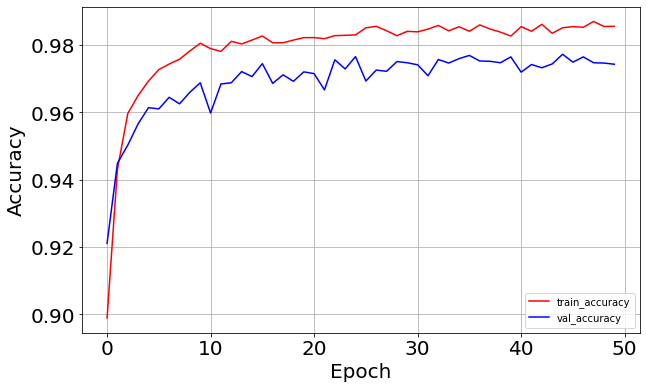

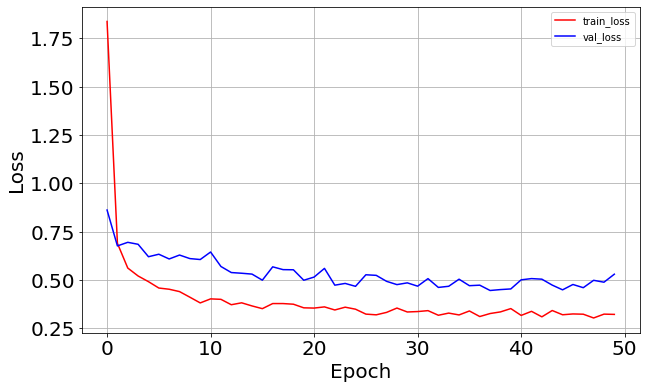

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_tuned.history['accuracy']), 'r', label='train_accuracy')
ax.plot(np.sqrt(model_tuned.history['val_accuracy']), 'b' ,label='val_accuracy')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
plt.grid()
ax.tick_params(labelsize=20)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_tuned.history['loss']), 'r', label='train_loss')
ax.plot(np.sqrt(model_tuned.history['val_loss']), 'b' ,label='val_loss')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
plt.grid()
ax.tick_params(labelsize=20)